In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score,confusion_matrix
from scipy.stats import chi2_contingency
from scipy.stats import mannwhitneyu
import math
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import RFE, RFECV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

from joblib import dump, load

In [4]:
def rfe_f_select(model, x_train, y_train):
  rfecv = RFECV(estimator = model, step = 1, cv = 5, scoring='accuracy').fit(x_train, y_train)
  print("Optimal number of features : %d" % rfecv.n_features_)
  print("Support is %s" % rfecv.support_)
  print("Ranking of features : %s" % rfecv.ranking_)

  return rfecv.n_features_, rfecv.support_

In [5]:
def grid_search(model, param_grid_, x_train, y_train_):
  optimal_params = GridSearchCV(
      model,
      param_grid,
      cv = 5,
      scoring = 'accuracy',
      verbose = 1,
      n_jobs = -1,
    )

  optimal_params.fit(x_train, y_train_)
  print(optimal_params.best_params_)

In [6]:
def ROC_and_AUC(label, score, name):
    fpr, tpr , _ = roc_curve(label, score)
    roc_auc = auc(fpr, tpr)
    name = name + '_auc = ' + str(roc_auc.round(3))
    lw = 2
    plt.plot(fpr, tpr, lw = lw, label = name)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc = "lower right")

In [7]:
def model_evaluation_result(X_train_Std, y_train, X_test_Std, y_test, model, roctrainname, roctestname):
    
    model.fit(X_train_Std, y_train)
    
    train_pred = model.predict(X_train_Std)
    score_train = model.decision_function(X_train_Std)
    train_acc = accuracy_score(y_train, train_pred)
    tn, fp, fn, tp = confusion_matrix(y_train, train_pred).ravel()
    train_specificity = tn / (tn+fp)
    train_sensitivity = tp / (tp+fn)
    train_PPV = tp / (tp+fp)
    train_NPV = tn / (fn+tn)
    train_MCC = ((tp*tn)-(fp*fn))/math.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    ROC_and_AUC(y_train, score_train, roctrainname)

    test_pred = model.predict(X_test_Std)
    score_test = model.decision_function(X_test_Std)
    test_acc = accuracy_score(y_test, test_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, test_pred).ravel()
    test_specificity = tn / (tn+fp)
    test_sensitivity = tp / (tp+fn)
    test_PPV = tp / (tp+fp)
    test_NPV = tn / (fn+tn)
    test_MCC = ((tp*tn)-(fp*fn))/math.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    ROC_and_AUC(y_test, score_test, roctestname)
    result = [{'Accuracy': train_acc,'Specificity': train_specificity, 'Sensitivity': train_sensitivity, 'MCC': train_MCC, 'PPV': train_PPV, 'NPV': train_NPV},
          {'Accuracy': test_acc,'Specificity': test_specificity, 'Sensitivity': test_sensitivity, 'MCC': test_MCC, 'PPV': test_PPV, 'NPV': test_NPV}]
    result_df = pd.DataFrame(result)
    result_df.index = ['Training set', 'Test_set']
    result_df = result_df.round(3)
    print(result_df)
    return result_df, score_train, train_pred, score_test, test_pred, model

In [8]:
def confusion_matrix_scorer(clf, X, y):
  y_pred = clf.predict(X)
  cm = confusion_matrix(y, y_pred)
  return {'tn': cm[0, 0], 'fp': cm[0, 1],'fn': cm[1, 0], 'tp': cm[1, 1]}

In [31]:
def print_cm(model, x_train, y_train):
  cv_results = cross_validate(model, x_train, y_train, cv = 5, scoring = confusion_matrix_scorer)
  tn = round(cv_results['test_tn'].mean())
  fp = round(cv_results['test_fp'].mean())
  fn = round(cv_results['test_fn'].mean())
  tp = round(cv_results['test_tp'].mean())
  accuracy = (tp+tn)/(tn+fp+fn+tp)
  precision = tp/(tp+fp)
  sensitivity = tp/(tp+fn)
  specificity = tn/(tn+fp)
  MCC = ((tp*tn)-(fp*fn))/math.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
  print(cv_results['test_tn'], round(cv_results['test_tn'].mean()))
  print(cv_results['test_fp'], round(cv_results['test_fp'].mean()))
  print(cv_results['test_fn'], round(cv_results['test_fn'].mean()))
  print(cv_results['test_tp'], round(cv_results['test_tp'].mean()))
  print('accuracy:', accuracy)
  print('precision:', precision)
  print('sensitivity:', sensitivity)
  print('specificity:', specificity)
  print('MCC:', MCC)

In [35]:
def proba_model_evaluation_result(X_train_Std, y_train, X_test_Std, y_test, model, roctrainname, roctestname):
    
    model.fit(X_train_Std, y_train)
    
    train_pred = model.predict(X_train_Std)
    score_train = model.predict_proba(X_train_Std)
    train_acc = accuracy_score(y_train, train_pred)
    tn, fp, fn, tp = confusion_matrix(y_train, train_pred).ravel()
    train_specificity = tn / (tn+fp)
    train_sensitivity = tp / (tp+fn)
    train_PPV = tp / (tp+fp)
    train_NPV = tn / (fn+tn)
    train_MCC = ((tp*tn)-(fp*fn))/math.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    ROC_and_AUC(y_train, score_train[:, 1], roctrainname)

    test_pred = model.predict(X_test_Std)
    score_test = model.predict_proba(X_test_Std)
    test_acc = accuracy_score(y_test, test_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, test_pred).ravel()
    test_specificity = tn / (tn+fp)
    test_sensitivity = tp / (tp+fn)
    test_PPV = tp / (tp+fp)
    test_NPV = tn / (fn+tn)
    test_MCC = ((tp*tn)-(fp*fn))/math.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    ROC_and_AUC(y_test, score_test[:, 1], roctestname)
    result = [{'Accuracy': train_acc,'Specificity': train_specificity, 'Sensitivity': train_sensitivity, 'MCC': train_MCC, 'PPV': train_PPV, 'NPV': train_NPV},
          {'Accuracy': test_acc,'Specificity': test_specificity, 'Sensitivity': test_sensitivity, 'MCC': test_MCC, 'PPV': test_PPV, 'NPV': test_NPV}]
    result_df = pd.DataFrame(result)
    result_df.index = ['Training set', 'Test_set']
    result_df = result_df.round(3)
    print(result_df)
    return result_df, score_train, train_pred, score_test, test_pred, model

In [13]:
df = pd.read_excel('train_dialysis.xlsx')

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
print(df)

        d1    d2    d3  d4   d5   d6    d7  d8   d9   d10  ...    c82    c83  \
0     1.61  1.71  1250   1  1.0  1.0  40.0   5  2.5  1250  ...  698.9  293.0   
1     1.61  1.71  1250   1  1.0  1.0  40.0   5  2.5  1250  ...  698.9  293.0   
2     1.61  1.71  1250   1  1.0  1.0  40.0   5  2.5  1250  ...  698.9  293.0   
3     1.61  1.71  1250   1  1.0  1.0  40.0   5  2.5  1250  ...  698.9  293.0   
4     1.61  1.71  1250   1  1.0  1.0  40.0   5  2.5  1250  ...  698.9  293.0   
...    ...   ...   ...  ..  ...  ...   ...  ..  ...   ...  ...    ...    ...   
7062  1.60  1.70  1250   1  1.0  1.0  20.0   1  2.5  1250  ...  260.8   84.0   
7063  1.60  1.70  1250   1  1.0  1.0  20.0   1  2.5  1250  ...  260.8   84.0   
7064  1.60  1.70  1250   1  1.0  1.0  20.0   1  2.5  1250  ...  260.8   84.0   
7065  1.60  1.70  1250   1  1.0  1.0  20.0   1  2.5  1250  ...  260.8   84.0   
7066  1.60  1.70  1250   1  1.0  1.0  20.0   1  2.5  1250  ...  260.8   84.0   

        c84   c85   c86   c87   c88    

In [15]:
train_df, test_df = train_test_split(df, train_size = 0.7, random_state = 0) 

In [16]:
#chi-square
cat_df = train_df.iloc[:,0:39]
cat_df = pd.concat([cat_df, train_df['label']], axis = 1)

cat_p_value = []
cat_df = cat_df[cat_df['label'] >= 0]
titles = list(cat_df.columns)

for i in titles:
    table = pd.crosstab(cat_df['label'],cat_df[i])
    chi2, p, dof, expected = chi2_contingency(table)
    cat_p_value.append(p) 
d1_d39_p_value = pd.DataFrame([titles, cat_p_value]).T
d1_d39_p_value = d1_d39_p_value.rename(columns = {0:'features', 1:'p_value'})

#Mann–Whitney U test
cont_df = train_df.iloc[:,39:90]
cont_df = pd.concat([cont_df, train_df['label']], axis = 1)
cont_df = cont_df[cont_df['label'] >= 0]
titles = list(cont_df.columns)

c_p_value = []
for i in titles:
    value1=[]
    value0=[]
    my_col = cont_df[[i,'label']]
    for j in range(0, my_col.shape[0]):
        if (str(my_col.iloc[j,1]) == '1'):
            value1.append(my_col.iloc[j,0])
        elif (str(my_col.iloc[j,1]) == '-1'):
            continue
        else:
            value0.append(my_col.iloc[j,0])
    result = mannwhitneyu(value0, value1, alternative= 'two-sided') 
    c_p_value.append(result[1])
c40_c90_p_value = pd.DataFrame([titles, c_p_value]).T
c40_c90_p_value = c40_c90_p_value.rename(columns = {0:'features', 1:'p_value'})
#print(c40_c90_p_value)
#print(d1_d39_p_value)

train_features = []
for i in d1_d39_p_value.iloc:
  if(i['p_value'] <= 0.05 and i['features'] != 'label'): train_features.append(i['features'])
for i in c40_c90_p_value.iloc:
  if(i['p_value'] <= 0.05 and i['features'] != 'label'): train_features.append(i['features'])

train_predata = train_df.loc[:,train_features]
test_predata = test_df.loc[:, train_features]

print(train_features)
print(train_predata)

['d1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8', 'd9', 'd11', 'd13', 'd14', 'd15', 'd20', 'd21', 'd22', 'd23', 'd24', 'd27', 'd28', 'd29', 'd30', 'd31', 'd32', 'd33', 'd34', 'd37', 'd39', 'c43', 'c45', 'c46', 'c49', 'c50', 'c51', 'c53', 'c55', 'c56', 'c59', 'c60', 'c61', 'c62', 'c64', 'c65', 'c66', 'c67', 'c70', 'c71', 'c72', 'c73', 'c74', 'c75', 'c78', 'c80', 'c82', 'c83', 'c84', 'c89', 'c90']
        d1     d2    d3  d4   d5   d6    d7  d8   d9  d11  ...   c73     c74  \
3318  1.70  1.800  1250   1  1.0  0.5  40.0   1  2.5    0  ...  12.6  2.9185   
2701  1.60  1.680  1000   2  1.0  1.0  40.0   1  2.5  500  ...  10.6  1.1365   
5862  1.60  1.700     0   2  2.0  1.0  50.0   1  2.5    0  ...  11.3  7.9100   
3595  1.64  1.735   250   1  1.0  0.5  40.0   1  3.0  250  ...  10.6  7.8165   
2377  1.60  1.680  1000   2  1.0  1.0  40.0   1  2.5  500  ...  11.4  1.1365   
...    ...    ...   ...  ..  ...  ...   ...  ..  ...  ...  ...   ...     ...   
4931  1.60  1.700     0   2  1.0  1.5  40.

In [17]:
y_train = train_df.iloc[:,-1]
y_test = test_df.iloc[:,-1]

scaler_Std = preprocessing.StandardScaler().fit(train_predata)
scaler_MinMax = preprocessing.MinMaxScaler().fit(train_predata)

x_pretrain_Std = scaler_Std.transform(train_predata)
x_pretest_Std = scaler_Std.transform(test_predata)
x_pretrain_MinMax = scaler_MinMax.transform(train_predata)
x_pretest_MinMax = scaler_MinMax.transform(test_predata)

#print(x_pretrain_Std)
print(x_pretrain_MinMax)
print(x_pretest_MinMax)

[[0.33333333 0.8        1.         ... 0.47081712 0.88135593 0.30666667]
 [0.         0.56       0.8        ... 0.45914397 0.88135593 0.41666667]
 [0.         0.6        0.         ... 0.02723735 0.         0.13333333]
 ...
 [0.1        0.64       0.6        ... 0.28404669 0.88135593 0.38333333]
 [0.26666667 0.76       0.8        ... 0.14007782 0.88135593 0.49333333]
 [0.         0.54       0.8        ... 0.45914397 0.88135593 0.41666667]]
[[0.13333333 0.68       1.         ... 0.54863813 0.88135593 0.76666667]
 [0.         0.55       0.8        ... 0.64980545 0.88135593 0.26666667]
 [0.         0.54       0.8        ... 0.22178988 0.88135593 0.96      ]
 ...
 [0.03333333 0.57       0.8        ... 0.64980545 0.88135593 0.26666667]
 [0.08333333 0.59       0.8        ... 0.38132296 0.88135593 0.30666667]
 [0.1        0.64       1.         ... 0.17120623 0.79322034 0.34333333]]


**SVC**

In [9]:
svc = SVC(kernel = 'linear')
n_feature, selected = rfe_f_select(svc, x_pretrain_Std, y_train)

Optimal number of features : 43
Support is [ True False  True  True  True  True  True  True  True False False False
  True  True False  True  True  True  True  True  True False  True  True
  True  True  True False  True False False False  True  True  True  True
  True  True False  True False False False  True  True  True  True  True
  True  True  True  True  True  True  True False  True  True]
Ranking of features : [ 1 15  1  1  1  1  1  1  1  5  9  3  1  1 16  1  1  1  1  1  1 12  1  1
  1  1  1  6  1  7 11 10  1  1  1  1  1  1  8  1  2  4 14  1  1  1  1  1
  1  1  1  1  1  1  1 13  1  1]


In [10]:
svc_train_data = train_predata.loc[:, selected]
svc_test_data = test_predata.loc[:, selected]

# print(svc_train_data.columns)
# print(svc_train_data)
# print(svc_test_data)

In [11]:
svc_scaler_Std = preprocessing.StandardScaler().fit(svc_train_data)

svc_scaler_MinMax = preprocessing.MinMaxScaler().fit(svc_train_data)
svc_x_train_Std = svc_scaler_Std.transform(svc_train_data)
svc_x_test_Std = svc_scaler_Std.transform(svc_test_data)
#svc_x_train_MinMax = svc_scaler_MinMax.transform(svc_train_data)
#svc_x_test_MinMax = svc_scaler_MinMax.transform(svc_test_data)

print(svc_x_train_Std)

[[ 1.07689771  0.98260277 -0.5702343  ... -1.58739438  0.25256772
  -0.33489454]
 [-0.72008145  0.48048961  0.50501498 ... -0.81229314  0.25256772
   0.09048478]
 [-0.72008145 -1.52796304  0.50501498 ...  0.76044135 -5.01003395
  -1.00518923]
 ...
 [-0.1809877  -0.02162356  0.50501498 ...  0.70185812  0.25256772
  -0.03841805]
 [ 0.71750188  0.48048961  0.50501498 ...  1.32824808  0.25256772
   0.38696127]
 [-0.72008145  0.48048961  0.50501498 ... -0.81229314  0.25256772
   0.09048478]]


In [24]:
param_grid = {
        'kernel': ['linear', 'rbf'],
        'C': [1, 4, 10, 12, 14, 16],
        'gamma': [0.001, 0.01, 0.1, 1, 10]
        }

model = SVC()
grid_search(model, param_grid, svc_x_train_Std, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
{'C': 12, 'gamma': 1, 'kernel': 'rbf'}


              Accuracy  Specificity  Sensitivity    MCC    PPV    NPV
Training set     0.974        0.981        0.952  0.933  0.949  0.983
Test_set         0.830        0.895        0.651  0.557  0.692  0.876


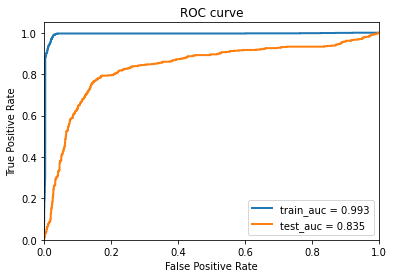

[668 660 661 655 655] 660
[57 64 63 69 69] 64
[ 89  83  99  95 110] 95
[176 182 166 170 155] 170
accuracy: 0.839231547017189
precision: 0.7264957264957265
sensitivity: 0.6415094339622641
specificity: 0.9116022099447514
MCC: 0.5763995282854502


In [18]:
svc_model = SVC(kernel = 'rbf', C = 12, gamma = 1)
svc_model.fit(svc_x_train_Std, y_train)
plt.figure()
df_svc, tr_predsc, tr_predlabel, te_predsc, te_predlabel, model = model_evaluation_result(svc_x_train_Std, y_train, svc_x_test_Std, y_test, svc_model, 'train', 'test')
plt.show()
print_cm(svc_model, svc_x_train_Std, y_train)

**KNN**

[0.20441033183196988, 0.2060248593110069, 0.20905720501271563, 0.2108762038994597, 0.21128351257774924, 0.20845114440665502, 0.20359939128392113, 0.21027075609482082, 0.2112822869749058, 0.2135053262656903, 0.2153259592895589, 0.2163370816353627, 0.21835850925840805, 0.22341452952170848, 0.2236171625251504, 0.22725597736720082, 0.2288739773876276, 0.22988285279488507, 0.2317020559487697, 0.23150044428103078]
[0.20441033183196988, 0.20441033183196988, 0.20137553492457427, 0.19915106576380592, 0.19773876275392954, 0.19571631379518128, 0.1940981095076142, 0.1932892116309709, 0.19591669986007698, 0.19450092430881105, 0.19713025094218217, 0.19814116902084533, 0.1973328839456242, 0.19915269990093043, 0.20137635199313664, 0.20279151474298085, 0.20622830938301107, 0.20562163597552874, 0.2086552072800809, 0.2052184126400507]


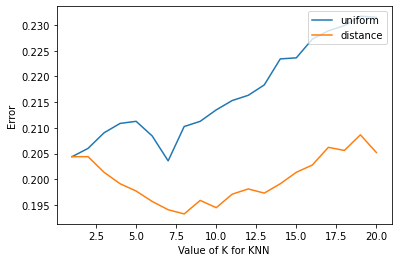

In [20]:
k_range = range(1, 21)
uni_k_error = []
dis_k_error = []

for method in ["uniform", "distance"]:
  for k in k_range:
      knn = KNeighborsClassifier(n_neighbors=k, weights = method)
      scores = cross_val_score(knn, x_pretrain_Std, y_train, cv=5, scoring='accuracy')

      if(method == 'uniform'): uni_k_error.append(1 - scores.mean())
      else: dis_k_error.append(1 - scores.mean())

print(uni_k_error)
print(dis_k_error)
plt.plot()
unifrom, = plt.plot(k_range, uni_k_error, label = 'uniform')
distance, = plt.plot(k_range, dis_k_error, label = 'distance')
plt.xlabel('Value of K for KNN')
plt.ylabel('Error')
plt.legend(handles = [unifrom, distance], loc='upper right')
plt.show()

[0.20279253607868364, 0.21289844859106744, 0.21593161136133832, 0.21431463267661444, 0.2126984710604528, 0.2120907763172677, 0.20966449122161968, 0.21411302100887541, 0.21653951037166408, 0.22078499862119683, 0.2234124868503028, 0.22401895599064459, 0.2262415867471479, 0.22866909744563946, 0.2290749762539448, 0.22887316031906524, 0.2308956092778136, 0.23251074955827222, 0.23554411659568386, 0.2353429134622259]
[0.20279253607868364, 0.20279253607868364, 0.20198200406491607, 0.20279090194155924, 0.19955817017495492, 0.19773794568536718, 0.1940977009733329, 0.1955128637231771, 0.19530941365117305, 0.19632094453125803, 0.20056643278079067, 0.19793731041456009, 0.1981409647537049, 0.19773549447968064, 0.19935369876724773, 0.1997579434384289, 0.20319494234559965, 0.20481253383174525, 0.2058238604446896, 0.20764388066713646]


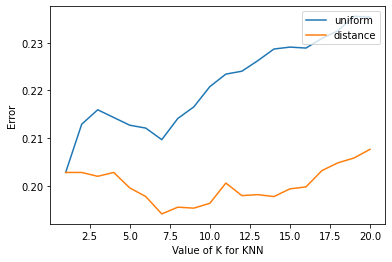

In [21]:
k_range = range(1, 21)
uni_k_error = []
dis_k_error = []

for method in ["uniform", "distance"]:
  for k in k_range:
      knn = KNeighborsClassifier(n_neighbors=k, weights = method)
      scores = cross_val_score(knn, x_pretrain_MinMax, y_train, cv=5, scoring='accuracy')

      if(method == 'uniform'): uni_k_error.append(1 - scores.mean())
      else: dis_k_error.append(1 - scores.mean())

print(uni_k_error)
print(dis_k_error)
plt.plot()
unifrom, = plt.plot(k_range, uni_k_error, label = 'uniform')
distance, = plt.plot(k_range, dis_k_error, label = 'distance')
plt.xlabel('Value of K for KNN')
plt.ylabel('Error')
plt.legend(handles = [unifrom, distance], loc='upper right')
plt.show()

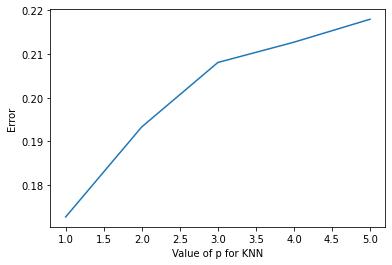

In [23]:
p_range = range(1, 6)
p_error = []

for p in p_range:
    knn = KNeighborsClassifier(n_neighbors= 8, weights = 'distance', p = p)
    
    scores = cross_val_score(knn, x_pretrain_Std, y_train, cv=5, scoring='accuracy')
    p_error.append(1 - scores.mean())


plt.plot(p_range, p_error)
plt.xlabel('Value of p for KNN')
plt.ylabel('Error')
plt.show()

              Accuracy  Specificity  Sensitivity    MCC    PPV    NPV
Training set     1.000        1.000        1.000  1.000  1.000  1.000
Test_set         0.819        0.878        0.656  0.535  0.661  0.876


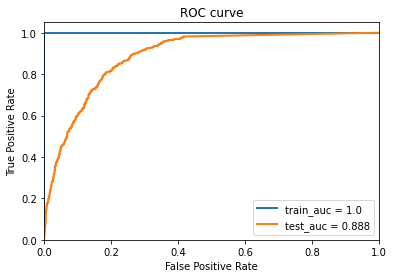

[656 639 640 646 653] 647
[69 85 84 78 71] 77
[88 94 94 95 96] 93
[177 171 171 170 169] 172
accuracy: 0.8281092012133469
precision: 0.6907630522088354
sensitivity: 0.6490566037735849
specificity: 0.893646408839779
MCC: 0.5537821066397217


In [29]:
knn_model = KNeighborsClassifier(n_neighbors= 8, weights = 'distance', p = 1)
knn_model.fit(x_pretrain_Std, y_train)
plt.figure()
df_knn, tr_predsc, tr_predlabel, te_predsc, te_predlabel, model = proba_model_evaluation_result(x_pretrain_Std, y_train, x_pretest_Std, y_test, knn_model, 'train', 'test')
plt.show()
print_cm(knn_model, x_pretrain_Std, y_train)

**RF**

In [48]:
rf = RandomForestClassifier()
n_feature, selected = rfe_f_select(rf, x_pretrain_Std, y_train)

Optimal number of features : 3
Support is [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False  True  True False False False False False False False False False
  True False False False False False False False False False]
Ranking of features : [19  8 26 40 33 35 39 42 34 41 56 48 47 32 28 25 46 55 53 49 45 36 37 43
 44 52 51 54  2  4 11 23 30 38 31 27 24  1  1  3  7  6 18 14 15 21  5 12
  1 20  9 17 29 13 16 10 50 22]


In [49]:
rf_train_data = train_predata.loc[:, selected]
rf_test_data = test_predata.loc[:, selected]

print(rf_train_data.columns)
print(rf_train_data)
print(rf_test_data)

Index(['c59', 'c60', 'c73'], dtype='object')
       c59    c60   c73
3318  41.0  218.0  12.6
2701  32.1  116.0  10.6
5862  32.9  190.0  11.3
3595  33.6  263.0  10.6
2377  36.4  299.0  11.4
...    ...    ...   ...
4931  33.1  236.0  10.3
3264  33.2  256.0   9.2
1653  36.7  262.0  12.2
2607  32.0  283.0  10.7
2732  32.8   91.0  11.0

[4946 rows x 3 columns]
       c59    c60   c73
1091  33.4   84.0  12.0
2194  34.1  419.0  11.6
2921  37.7  187.0  12.2
878   24.4  136.0   8.6
3093  34.2  156.0  11.6
...    ...    ...   ...
6605  36.0  204.0  10.0
6698  31.5  129.0  10.7
2161  36.0  396.0  11.7
4462  36.7  234.0  11.3
1231  30.0   85.0   9.6

[2121 rows x 3 columns]


In [50]:
rf_scaler_Std = preprocessing.StandardScaler().fit(rf_train_data)

rf_scaler_MinMax = preprocessing.MinMaxScaler().fit(rf_train_data)
rf_x_train_Std = rf_scaler_Std.transform(rf_train_data)
rf_x_test_Std = rf_scaler_Std.transform(rf_test_data)

print(rf_x_train_Std)

[[ 2.31544328  0.28507844  1.56867342]
 [-0.14463792 -1.01898721 -0.17922595]
 [ 0.07649297 -0.07290036  0.43253883]
 ...
 [ 1.12686472  0.84761656  1.21909354]
 [-0.17227929  1.11610067 -0.09183098]
 [ 0.04885161 -1.33861114  0.17035393]]


In [45]:
param_grid = {
    'max_depth': [10, 20, 30, 40],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 4, 8],
    'n_estimators': [100, 150, 200, 250]
}

model = RandomForestClassifier()
grid_search(model, param_grid, rf_x_train_Std, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
{'max_depth': 40, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 250}


In [50]:
param_grid = {
    'max_depth': [40, 50, 60, 70],
    'criterion': ['entropy', 'gini'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 4, 8],
    'n_estimators': [250, 300, 350, 400]
}

model = RandomForestClassifier()
grid_search(model, param_grid, rf_x_train_Std, y_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
{'criterion': 'gini', 'max_depth': 70, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 350}


In [58]:
param_grid = {
    'max_depth': [70, 80, 90],
    'min_samples_leaf': [1],
    'min_samples_split': [2],
    'n_estimators': [300, 350, 400]
}

model = RandomForestClassifier()
grid_search(model, param_grid, rf_x_train_Std, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
{'max_depth': 80, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 350}


              Accuracy  Specificity  Sensitivity    MCC    PPV    NPV
Training set     0.975        0.983        0.952  0.936  0.955  0.982
Test_set         0.925        0.942        0.878  0.809  0.845  0.955


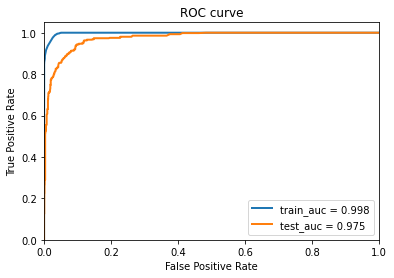

[689 692 684 681 688] 687
[36 32 40 43 36] 37
[35 43 51 46 47] 44
[230 222 214 219 218] 221
accuracy: 0.9180990899898888
precision: 0.8565891472868217
sensitivity: 0.8339622641509434
specificity: 0.9488950276243094
MCC: 0.7895984364684694


In [55]:
rf_model = RandomForestClassifier(max_depth= 80, min_samples_leaf=1, min_samples_split=2, n_estimators=350)
rf_model.fit(rf_x_train_Std, y_train)
plt.figure()
df_rf, tr_predsc, tr_predlabel, te_predsc, te_predlabel, model = proba_model_evaluation_result(rf_x_train_Std, y_train, rf_x_test_Std, y_test, rf_model, 'train', 'test')
plt.show()
print_cm(rf_model, rf_x_train_Std, y_train)

**Xgboost**

In [18]:
xgb = XGBClassifier()
n_feature, selected = rfe_f_select(xgb, x_pretrain_Std, y_train)

Optimal number of features : 28
Support is [ True  True  True False False  True  True  True False False False False
 False False False  True False False  True False False False False False
  True False False False False False False  True  True False False  True
 False  True  True  True  True  True  True  True  True  True  True  True
  True  True  True False False  True False  True False False]
Ranking of features : [ 1  1  1  6 10  1  1  1 23 25 18 17 15 19 20  1  3 13  1 27 28 26 24 22
  1 14 12 29  8  9 11  1  1 16  5  1  7  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  2 21  1  4  1 30 31]


In [19]:
xgb_train_data = train_predata.loc[:, selected]
xgb_test_data = test_predata.loc[:, selected]

print(xgb_train_data.columns)
print(xgb_train_data)
print(xgb_test_data)

Index(['d1', 'd2', 'd3', 'd6', 'd7', 'd8', 'd22', 'd27', 'd33', 'c49', 'c50',
       'c55', 'c59', 'c60', 'c61', 'c62', 'c64', 'c65', 'c66', 'c67', 'c70',
       'c71', 'c72', 'c73', 'c74', 'c75', 'c82', 'c84'],
      dtype='object')
        d1     d2    d3   d6    d7  d8  d22  d27  d33      c49  ...   c66  \
3318  1.70  1.800  1250  0.5  40.0   1    2    1  1.0  63.2108  ...   4.0   
2701  1.60  1.680  1000  1.0  40.0   1    2    1  1.0  67.2000  ...  10.0   
5862  1.60  1.700     0  1.0  50.0   1    1    1  1.0  52.5000  ...   7.0   
3595  1.64  1.735   250  0.5  40.0   1    2    1  1.0  51.5000  ...   8.0   
2377  1.60  1.680  1000  1.0  40.0   1    5    1  1.0  79.0000  ...  14.0   
...    ...    ...   ...  ...   ...  ..  ...  ...  ...      ...  ...   ...   
4931  1.60  1.700     0  1.5  40.0   1    3    1  1.0  74.0000  ...  16.0   
3264  1.70  1.800  1250  0.5  40.0   1    2    1  1.0  63.2108  ...   5.0   
1653  1.63  1.720   750  1.0  50.0   1    3    1  2.8  54.5000  ...   7.0

In [20]:
xgb_scaler_Std = preprocessing.StandardScaler().fit(xgb_train_data)

xgb_scaler_MinMax = preprocessing.MinMaxScaler().fit(xgb_train_data)
xgb_x_train_Std = xgb_scaler_Std.transform(xgb_train_data)
xgb_x_test_Std = xgb_scaler_Std.transform(xgb_test_data)

print(xgb_x_train_Std)

[[ 1.07689771  1.14526039  0.98260277 ... -0.56007403  0.53584392
   0.98242483]
 [-0.72008145 -0.85551947  0.48048961 ... -0.4147665   0.33472955
   0.90855437]
 [-0.72008145 -0.52205616 -1.52796304 ...  0.03436585 -0.0944944
  -1.82465261]
 ...
 [-0.1809877  -0.18859285 -0.02162356 ... -0.56007403 -0.33745135
  -0.19950251]
 [ 0.71750188  0.81179708  0.48048961 ... -0.8903184  -0.53091707
  -1.11057151]
 [-0.72008145 -1.02225113  0.48048961 ... -0.49402515  0.33472955
   0.90855437]]


In [27]:
random_grid = {
    'n_estimators':[100, 200, 300, 400],
    'max_depth': [20, 30, 40, 50, 60],
    'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.4],
    'gamma': [0.1, 1, 10]
}

model = XGBClassifier()
model_RSCV = RandomizedSearchCV(estimator = model, param_distributions=random_grid, n_iter=100, cv=5, verbose=1, n_jobs=-1)

model_RSCV.fit(xgb_x_train_Std,y_train)
print(model_RSCV.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.4, 'gamma': 0.1}


              Accuracy  Specificity  Sensitivity    MCC    PPV    NPV
Training set     0.983        0.989        0.968  0.958  0.970  0.988
Test_set         0.925        0.945        0.869  0.808  0.851  0.952


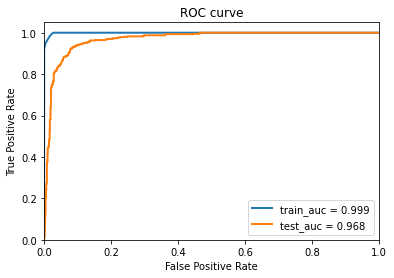

[690 699 684 690 689] 690
[35 25 40 34 35] 34
[30 41 38 43 40] 38
[235 224 227 222 225] 227
accuracy: 0.9271991911021233
precision: 0.8697318007662835
sensitivity: 0.8566037735849057
specificity: 0.9530386740331491
MCC: 0.8135786548404282


In [36]:
xgb_model = XGBClassifier(n_estimators=100, max_depth=20, learning_rate=0.4, gamma=0.1)
xgb_model.fit(xgb_x_train_Std, y_train)
plt.figure()
df_xgb, tr_predsc, tr_predlabel, te_predsc, te_predlabel, model = proba_model_evaluation_result(xgb_x_train_Std, y_train, xgb_x_test_Std, y_test, xgb_model, 'train', 'test')
plt.show()
print_cm(xgb_model, xgb_x_train_Std, y_train)

**儲存模型**

In [65]:
dump(rf_model, 'finalmodel.joblib')

['finalmodel.joblib']

In [66]:
test_model = load('finalmodel.joblib')

In [67]:
cv_results = cross_validate(test_model, rf_x_train_Std, y_train, cv = 5, scoring = confusion_matrix_scorer)
tn = round(cv_results['test_tn'].mean())
fp = round(cv_results['test_fp'].mean())
fn = round(cv_results['test_fn'].mean())
tp = round(cv_results['test_tp'].mean())
accuracy = (tp+tn)/(tn+fp+fn+tp)
precision = tp/(tp+fp)
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
MCC = ((tp*tn)-(fp*fn))/math.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
print(cv_results['test_tn'], round(cv_results['test_tn'].mean()))
print(cv_results['test_fp'], round(cv_results['test_fp'].mean()))
print(cv_results['test_fn'], round(cv_results['test_fn'].mean()))
print(cv_results['test_tp'], round(cv_results['test_tp'].mean()))
print('accuracy:', accuracy)
print('precision:', precision)
print('sensitivity:', sensitivity)
print('specificity:', specificity)
print('MCC:', MCC)

[689 690 690 678 690] 687
[36 34 34 46 34] 37
[37 42 50 45 45] 44
[228 223 215 220 220] 221
accuracy: 0.9180990899898888
precision: 0.8565891472868217
sensitivity: 0.8339622641509434
specificity: 0.9488950276243094
MCC: 0.7895984364684694
